In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

In [2]:
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

def plot_iicr(iirc,T): 
    plt.plot(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14);

In [6]:
N = 20e3
time_period = 0.1*N

<AxesSubplot:ylabel='time ago (generations)'>

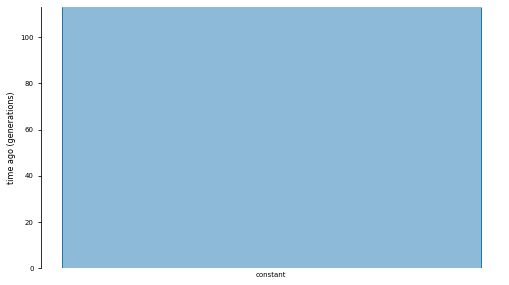

In [3]:
# Constant model
constant = demes.Builder()
constant.add_deme("constant",epochs=[dict(start_size=N)])
graph = constant.resolve()
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

### Size Change model

In [57]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    
    if time_units == "generations":
        generation_time=1

    m = demes.Builder(time_units=time_units,generation_time=generation_time)
    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph 

In [72]:
def sample_timepoints(graph,anc_end_time=100000):
    times = []
    times_dic = defaultdict()
    for deme in graph.demes:
        time = []
        for epoch in deme.epochs:
            start = (epoch.start_time if epoch.start_time != float('inf') else anc_end_time)
            midway = (start + epoch.end_time)/2
            time.extend([start-1, midway, epoch.end_time])
        times = np.concatenate([times,time])
        times_dic[deme.name] = time
    return np.unique(np.flip(times)),times_dic

[{'start_size': 20000.0, 'end_time': 4000.0}, {'start_size': 2000.0, 'end_time': 1000.0}, {'start_size': 20000.0, 'end_time': 0.0}]


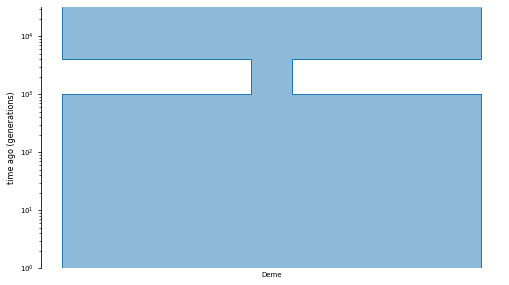

In [55]:
#Size change model
sc_model = size_change(Ns=[N,N/10,N],time_period=[time_period,time_period*1.5,time_period/2],time_units="generations")

In [73]:
T,times_dic = sample_timepoints(sc_model)
times_in_gen = T/29
times_in_gen[0] = 1

In [64]:
sc_model.demes

[Deme(name='Deme', description='', start_time=inf, ancestors=[], proportions=[], epochs=[Epoch(start_time=inf, end_time=4000.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=4000.0, end_time=1000.0, start_size=2000.0, end_size=2000.0, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=1000.0, end_time=0.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0)])]

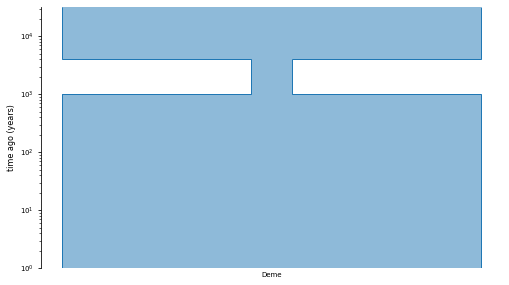

In [75]:
sc_R, sc_iicr, _ = model.get_iicr(sc_model,pop="Deme",T=T)
sc_sc = model.size_change_from_iicr(sc_iicr,T,time_units="years")

In [50]:
times_in_gen

array([1.00000000e+00, 1.72413793e+01, 3.44827586e+01, 3.45172414e+01,
       8.62068966e+01, 1.37931034e+02, 1.37965517e+02, 1.79310345e+03,
       3.44827586e+03])

In [43]:
sc_model.demes

[Deme(name='Deme', description='', start_time=inf, ancestors=[], proportions=[], epochs=[Epoch(start_time=inf, end_time=4000.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=4000.0, end_time=1000.0, start_size=2000.0, end_size=2000.0, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=1000.0, end_time=0.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0)])]

In [36]:
sc_sc.demes

[Deme(name='Deme', description='', start_time=inf, ancestors=[], proportions=[], epochs=[Epoch(start_time=inf, end_time=2500.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=2500.0, end_time=500.0, start_size=2000, end_size=2000, size_function='constant', selfing_rate=0, cloning_rate=0), Epoch(start_time=500.0, end_time=0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0)])]

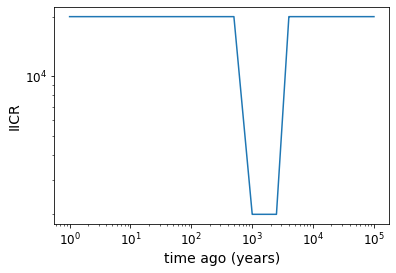

In [44]:
plot_iicr(sc_iicr,T)

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=603000.0)]


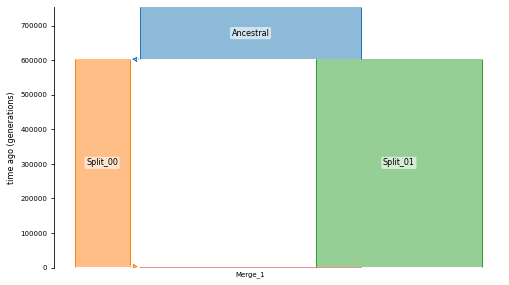

In [4]:
# Bubble
bubble = model.cake_model(Ns=[N,N],splits=[3],proportions=[[0.25,0.75]],time_period_merge=[N,time_period],time_period_splits=[20*N],migration_rate=0.02)

In [8]:
bubble_R,bubble_iirc,bubble_T = model.get_iirc(bubble,pop="Merge_1")

In [12]:
bubble_T

array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 1.4930e+04, 1.4965e+04,
       1.5000e+04])

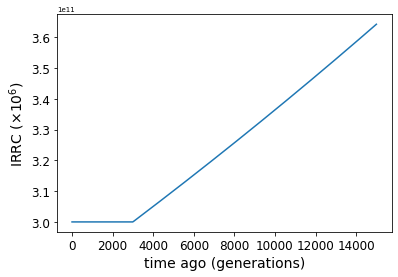

In [11]:
plt.plot(bubble_T, bubble_irrc*10e6)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel("time ago (generations)",fontsize = 14)
plt.ylabel(r"IICR ($\times 10^6$)",fontsize = 14);
plt.show()

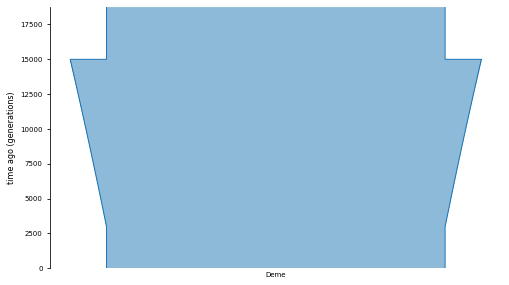

In [10]:
# Size change from bubble
bubble_NC = model.size_change_from_IIRC(bubble_irrc,bubble_T)

In [13]:
bubble_NC_R,bubble_NC_irrc,bubble_NC_T = model.get_iirc(bubble_NC,pop="Deme")

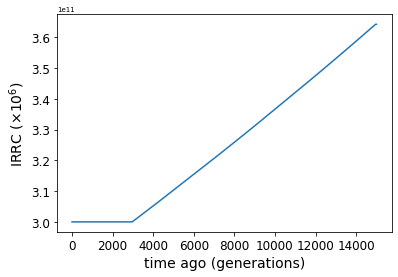

In [14]:
plt.plot(bubble_NC_T, bubble_NC_irrc*10e6)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel("time ago (generations)",fontsize = 14)
plt.ylabel(r"IRRC ($\times 10^6$)",fontsize = 14);
plt.show()

In [321]:
# Get Dstats - bubble
y = get_LD.Dstat(bubble,sampled_demes=["Merge_1"],rhos = np.logspace(-2, 2, 21),normalize=1)
"""
y = moments.LD.LDstats(
    [(y_l + y_r) / 2 for y_l, y_r in zip(y[:-2], y[1:-1])] + [y[-1]],
    num_pops=y.num_pops,
    pop_ids=y.pop_ids,
)
"""
y = moments.LD.Inference.sigmaD2(y)

In [322]:
# Get Dstats - bubble NC
y2 = get_LD.Dstat(bubble_NC,sampled_demes=["Deme"],rhos = np.logspace(-2, 2, 21),normalize=1)
"""
y2 = moments.LD.LDstats(
    [(y_l + y_r) / 2 for y_l, y_r in zip(y2[:-2], y2[1:-1])] + [y2[-1]],
    num_pops=y2.num_pops,
    pop_ids=y2.pop_ids,
)
"""
y2 = moments.LD.Inference.sigmaD2(y2)

In [15]:
rhos = np.logspace(-2, 2, 21)

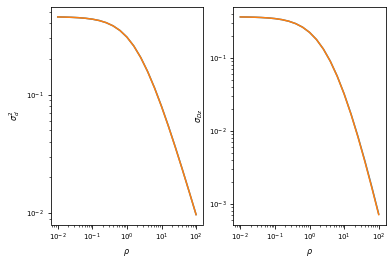

In [324]:
# plot D2
plt.subplot(1,2,1)
plt.plot(rhos,y.LD()[:,0])
plt.plot(rhos,y2.LD()[:,0])
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\sigma_d^2$")
plt.xlabel(r"$\rho$")

# plot DZ
plt.subplot(1,2,2)
plt.plot(rhos,y.LD()[:,1])
plt.plot(rhos,y2.LD()[:,1])
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\sigma_{Dz}$")
plt.xlabel(r"$\rho$")
plt.show()

In [16]:
# get times to slice
times = np.flip(np.linspace(bubble['Merge_1'].end_time,bubble['Merge_1'].start_time,30,dtype=int))
times_dic = {'Merged_1':times}
times_dic_NC = {'Deme':times}
# Actually slice
bubble_sliced = slice.slice_timepoints(bubble,time_points=times)
bubble_sliced_LD = get_LD.get_LD_from_sliced_demes(bubble_sliced)

bubbleNC_sliced = slice.slice_timepoints(bubble_NC,time_points=times)
bubbleNC_sliced_LD = get_LD.get_LD_from_sliced_demes(bubbleNC_sliced)

In [17]:
times_dic = {'Merge_1':times}
times_dic_NC = {'Deme':times}

In [18]:
times

array([3000, 2896, 2793, 2689, 2586, 2482, 2379, 2275, 2172, 2068, 1965,
       1862, 1758, 1655, 1551, 1448, 1344, 1241, 1137, 1034,  931,  827,
        724,  620,  517,  413,  310,  206,  103,    0])

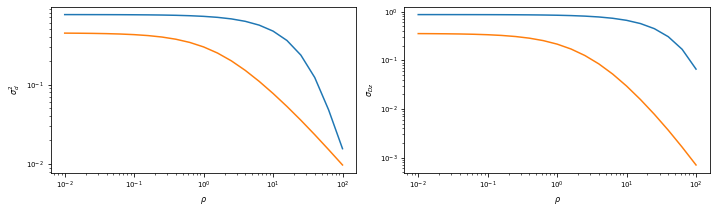

In [22]:
t1 = bubble_sliced_LD['Merge_1'][-1]
t1_NC = bubbleNC_sliced_LD['Deme'][-1]

# plot D2
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(rhos,t1[:,0])
ax.plot(rhos,t1_NC[:,0])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"$\sigma_d^2$")
ax.set_xlabel(r"$\rho$")

# plot DZ
#plt.subplot(1,2,2)
ax2.plot(rhos,t1[:,1])
ax2.plot(rhos,t1_NC[:,1])
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel(r"$\sigma_{Dz}$")
ax2.set_xlabel(r"$\rho$")

plt.tight_layout()
#plt.show()
plt.savefig("Deep_split_20N.pdf",format='pdf',transparent = False)

In [ ]:
# Structured - No migration
cake = model.cake_model(Ns=[N,N,N],splits = [3,2],proportions=[[1/2,0.3,0.2],[1/3,2/3]],migration_rate=0,time_period_merge=[time_period,time_period,time_period],time_period_splits=[time_period,time_period])

In [ ]:
cake_R,cake_irrc,cake_T = model.get_iirc(cake,pop="Merge_2")

In [ ]:
plt.plot(cake_T, cake_R*10e6)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel("time ago (generations)",fontsize = 14)
plt.ylabel(r"coalescence rate ($\times 10^6$)",fontsize = 14);
plt.show()

In [ ]:
# Change of size from structured model
cake_NC = model.size_change_from_IIRC(cake_irrc,cake_T)

In [ ]:
## LD
y = get_LD.Dstat(cake,sampled_demes=["Merge_2"],rhos = np.logspace(-2, 2, 21),normalize=0)
y = moments.LD.LDstats(
    [(y_l + y_r) / 2 for y_l, y_r in zip(y[:-2], y[1:-1])] + [y[-1]],
    num_pops=y.num_pops,
    pop_ids=y.pop_ids,
)
y = moments.LD.Inference.sigmaD2(y)

In [ ]:
moments.LD.Plotting.plot_ld_curves(y,stats_to_plot=[["DD_0_0"], ["Dz_0_0_0"]],rs=[],statistics=None)

In [ ]:
LD_cake